### Autor: Maciej Stefaniak

In [1]:
# !pip install gym torch matplotlib numpy box2d
!pip install gym[box2d] torch matplotlib numpy 

#!pip install pyglet==1.5.15



In [2]:
import gym

In [3]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [4]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards)
    return rewards    

Wykorzystywane urządzenie obliczeniowe
Procesor na którym były testowane algorytmy: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, 2304 MHz, Rdzenie: 4, Procesory logiczne: 8; Pamięć RAM: 16 GB


Ostateczna implementacja i dobranie parametrów daje aganta który potrafi nauczyć się w środowisku "CartPole-v1" idelnej polityki - 500p prosta linia wykresu - w około 3 minuty.

Spadek jakości zostaje zaobserwowany przez zejście polityki z optymalnego stanu poprzez losowe ruchy i wysokie uczenie (parametr epsilon i alfa).
                        Rozwiązaniem tego było zmniejszanie z czasem parametrów alfa i epsilon.


In [5]:
import numpy as np
import pandas as pd

In [6]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, gamma=1, alpha=1, epsilon=0.7, alpha_decrease = 0.001, epsilon_decrease = 0.001):
        super().__init__(env)
        self.space_discrete = np.array([10, 10, 20, 20])
        self.space_limits_low  = np.array([-4.8, -2, -0.419, -2])
        self.space_limits_step = (np.abs(self.space_limits_low*2))/self.space_discrete
        
        # jako że korzystany z polityki wyboru kolejnego stanu epsilon-greedy, 
        # nie jest ważne jak uzupełnione zostaną stany początkowe
        self.Q = np.zeros(np.concatenate([self.space_discrete, [self.action_space.n]]))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.alpha_decrease=alpha_decrease
        self.epsilon_decrease=epsilon_decrease

    

    def __to_descrete(self, observation) -> tuple:
        ret = np.zeros(len(observation), dtype=np.int32)
        for i, e in enumerate(self.space_discrete):
            if observation[i] < self.space_limits_low[i]:
                ret[i] = (int)(0)
                continue
            if observation[i] > -self.space_limits_low[i]:
                ret[i] = (int)(e-1)
                continue
            ret[i] = (int)((observation[i] - self.space_limits_low[i])/self.space_limits_step[i])
        
        return (tuple)(ret)


    def process_transition(self, observation, action, reward, next_observation, done):
        descrete_state = self.__to_descrete(observation)
        descrete_next_state = self.__to_descrete(next_observation)
        Qt = self.Q[descrete_state][action]
        Qmax = np.max(self.Q[descrete_next_state])

        
        if done:
            self.epsilon = max(0, self.epsilon - self.epsilon * self.epsilon_decrease)
            self.alpha = max(0, self.alpha - self.alpha * self.alpha_decrease)

        self.Q[descrete_state][action] = Qt - self.alpha*(Qt - (reward + self.gamma*Qmax))


    def get_action(self, observation, learning):
        pis = self.__to_descrete(observation)
        by_policy = self.Q[pis]
        by_policy = np.argmax(by_policy)

        if learning:
            action = np.random.choice(
                [by_policy, self.action_space.sample()], 1, True, 
                [1 - self.epsilon, self.epsilon])[0]
        else:
            action = by_policy

        return action

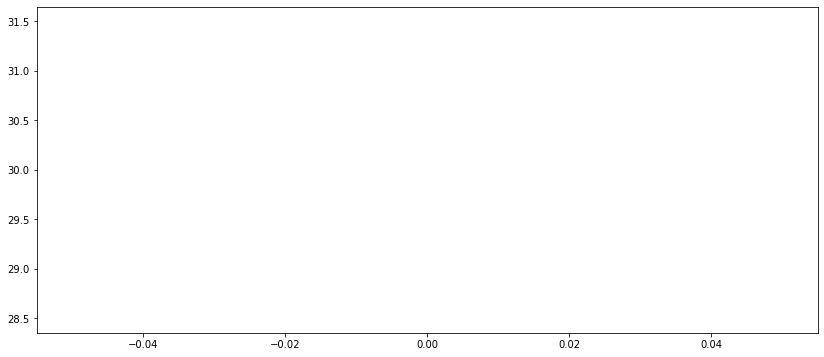

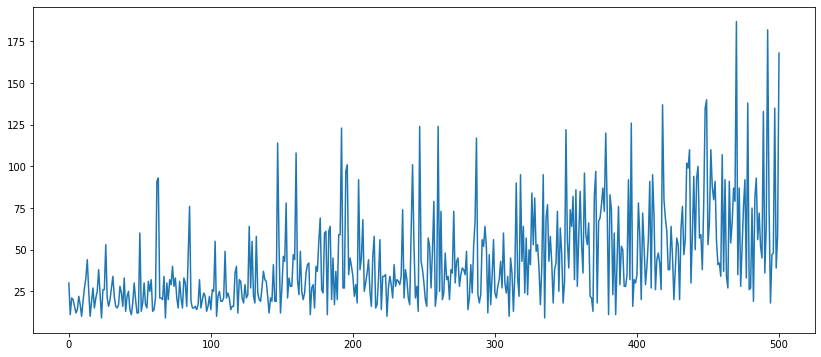

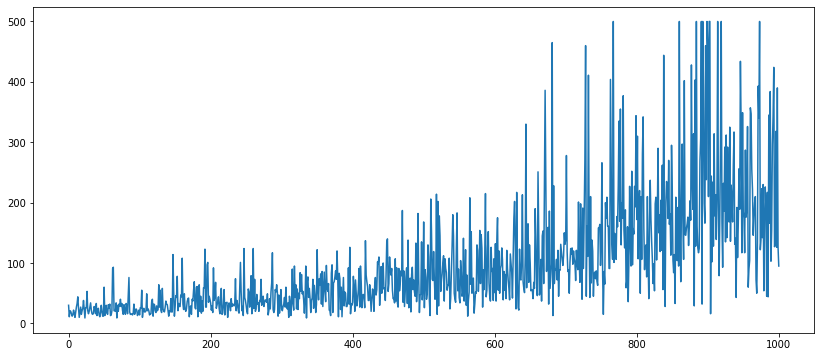

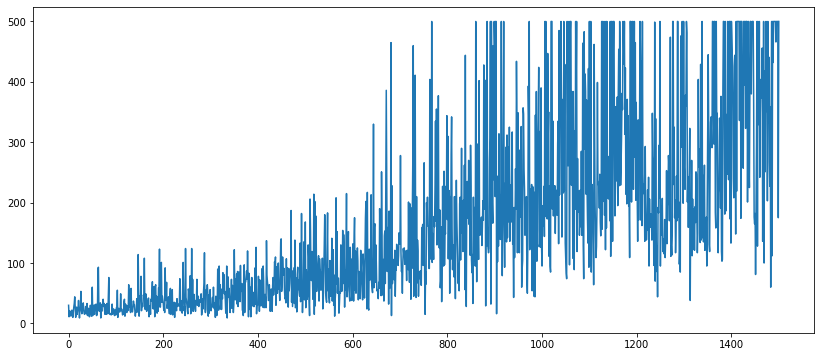

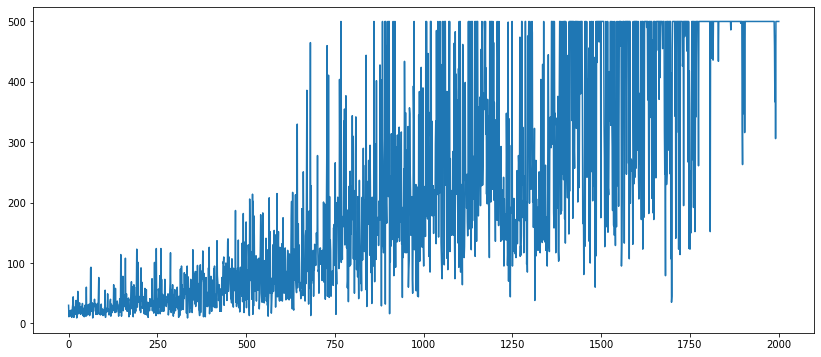

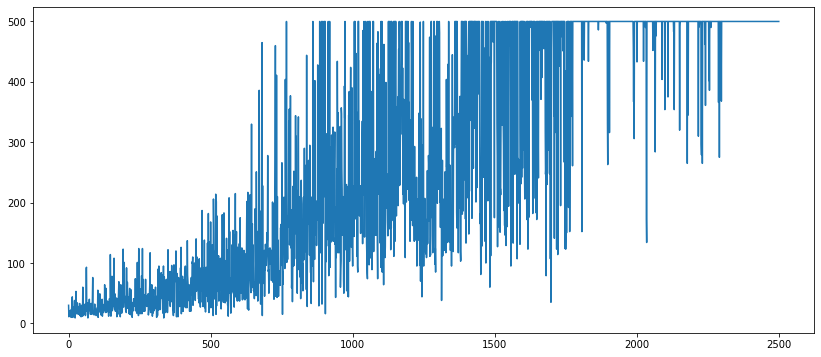

In [7]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 3000, learning=True, plot=True, plot_interval=500)

Q-Learning z aproksymacją

W komórkach poniżej zaimplementowany zsotał Q-Learning z aproksymacją dla środowiska `LunarLander`. Jako aproksymator użyta została prosta sieć neuronową zaimplementowanowa z wykorzystaniem biblioteki PyTroch. Dodatkowymi usprawnieniami są:
- uczenia batchowe
- network freezing
- double q-learning


Wykorzystywane urządzenie obliczeniowe
Procesor, na którym były testowane algorytmy: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, 2304 MHz, Rdzenie: 4, Procesory logiczne: 8; Pamięć RAM: 16 GB

Dostrajanie parametrów agenta nawet dla 10x łatwiejszego czasowo problemu wózka "CartPole-v1" zajmowało sporo czasu. Czasami w problemie "LunarLander-v2" agent działał lepiej niż w środowisku wózka. Stąd też decyzja o poszukiwaniu optymalnych parametrów ręcznie niż grid search'em. Ma to zalety związane z intuicyjnym dobieraniem parametrów przez człowieka na odstawie znajomości działania algorytmu i charakterystyk wykresu zachowania się agenta podczas uczenia, wyczytanych z wykresu.

Zaimplementowane techniki:
- Aproksymacyjny model stanów Q będący siecią neuronową o architekturze (8x256x4) z biasem, przejścia w postaci funkcji ReLU.
- Uczenie batchowe: i - liczba akcji po których następuje ucznie, j - ilość stanów losowo pobieranych z pamięci w celu nauki, batch_max - maksymalna przechowywana ilość stanów stanów (stare są usuwane).
- Dyskont z czasem parametru epsilon - stochastyczny wybór akcji podczas uczenia.
- Network freezing: akcje pobierane są z sieci która była siecią polityki z przeszłości przesuniętej ilość akcji równej czasowi zamrożenia, rzeczywista sieć polityki uczy się niezależnie. Generująca sieć aktualizowana jest o optymalizację polityki co pewien okres.
- Double q-learning: sieć spogląda dwa kroki w przód przy generowaniu z sieci maksymalnej nagrody przyszłego stanu.

Ręcznie zostały zbadane różne kombinacje następujących parametrów (zwykle podczas doborze odpowiedniej wartości parametru, musiały być brane pod uwagę wpływy innych).
Sprawdzone warianty:
- architektura ukrytych warstw sieci neuronowej: 8x16, 8x16x8, 64, 64x64, 64x64x64x64, 128, 128x128, 64x128, 256, 128x256,
- pręskość uczenia - intensywność zmian wag: 0.0005, 0.005, 0.0002, 0.05
- spadek epsilonu: (spadek po każdym uczeniu), (spadek po każdej akcji), (wartości: 0.001, 0.003, 0.005, 0.0001, 0.0005, 0.0003, 0.00005, 0.0001)
- wartość dyskontu gamma: 1, 0.999, 0.99, 0.7, 0.5, 0
- wielkośc batchu różne kombinacje następujących wartości: (i: 64, 128, 100, 200, 500), (j: 64, 128, 256, 100, 200, 300, 500, 1000), (max wielkość: inf, 10000, 4000, 2000, 256, 128, 64)
- różne kombinacje technik i ich parametrów: double q, network freeze (time: 4, 20, 100), batch

Wybrane parametry:
- warstywy ukryte sieci: 1 warstwa - 256 neuronów
- batch: i=100, j=500, batch_max=10000(inf - nie zapełnia się w czasie ucznia)
- spadek epsilonu: 0.0005, po każdej akcji, minimalna watość, do której spada to 0.1
- network freezing (time=20), batching, double q
- intensywność uczenia sieci: 0.0005

Wnioski
- Dobrze do testowania różnych ustawień i parametrów nadaje się środowisko Google Coolab, dając do dyspozycji wiele rdzeni do równoległego testowania.
- Wielowarstwowe sieci nie działały zbyt dobrze, prawdopodobnie potrzebowały dłuższego czasu uczenia lub innych parametrów agenta przekładających się na prędkość uczenia
- Przy usuwaniu stanów zapisanych w batchu sieć "zapominała" dobrych zachowań, najlepiej było zachować wielkość nieskończoną dla danego czasu uczenia.
- Sieć uczy się długo aby uzyskać dobre wyniki, dla środowiska "CartPole-v1" była nawet wolniejsza niż jej tabelaryczna wersja. Otrzymuje idealnego agenta w mniej niż 5 minut, tabularnej wersji mniej niż 4 minuty.
- Przy dobrze dobranych parametrach sieć może się uczyć ciągle bez statków (dopóki wszystkie stany są wciąż zapisane w batchu)
- Agent uczy się lepiej przy przetwarzaniu batchowym, kiedy j > i. Lepiej wtedy przyswaja sobie stany które odwiedził.
- Dla opisanego wcześniej urządzenia i środowiska "LunarLander-v2" agent zsiecią uczy się powolnie, ale stabilnie. Uzyskuje średnio 100 punktów po ok. 13 minutach i 200 punktów po ok. 25 minutach (dla wybranych parametrów).

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Q_model(nn.Module):

    def __init__(self, input_n, output_n):

        super().__init__()
        model = nn.Sequential()
        model.add_module(f'Linear{1}', nn.Linear(input_n, 256))
        model.add_module(f'Activation{1}', nn.ReLU())

        model.add_module(f'Linear{2}', nn.Linear(256, 256))
        model.add_module(f'Activation{2}', nn.ReLU())

        # model.add_module(f'Linear{3}', nn.Linear(64, 64))
        # model.add_module(f'Activation{3}', nn.ReLU())

        model.add_module(f'Linear{3}', nn.Linear(256, output_n))
        self.model = model

    def forward(self, state):
        return self.model(state)
        

class Mem():
    def __init__(self, max_size):
        self.memory = []
        self.max_size = max_size
    
    def append(self, data):
        self.memory.append(data)
        if len(self.memory) > self.max_size*2:
            self.memory = self.memory[-self.max_size:]

    def get_random(self, n):
        nsn = np.min([self.max_size, len(self.memory)])
        choosen = np.random.choice([i for i in range(len(self.memory)-nsn, len(self.memory))], n, True)
        tem = np.array(self.memory)[choosen]
        return tem.T


        

In [28]:
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NeuralQLearningAgent(Agent):
    def __init__(self, env, gamma=0.99, alpha=1, epsilon=1, alpha_decrease = 0.001,
        epsilon_decrease = 0.0005, learning_rate = 0.0005, batch_i=100, batch_j=500, batch_max=10000,
        network_freezing=True, freez_time=20, batching=True, double_q=True):
        super().__init__(env)

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.alpha_decrease=alpha_decrease
        self.epsilon_decrease=epsilon_decrease

        inputs_n = env.observation_space.shape[0]
        outputs_n = self.action_space.n

        self.Qnn_policy = Q_model(inputs_n, outputs_n).to(device)
        self.Qnn_target = Q_model(inputs_n, outputs_n).to(device) if network_freezing else self.Qnn_policy
        self.optimizer = optim.Adam(self.Qnn_policy.parameters(), lr=learning_rate)
        self.loss = nn.MSELoss()

        self.batching = batching
        self.state_c = 0
        self.batch_i = batch_i
        self.batch_j = batch_j

        if self.batch_i != 0:
            self.M = Mem(batch_max)

        self.network_freezing = network_freezing
        self.sync_freq = freez_time
        self.episode = 0

        self.double_q = double_q

        

    def process_transition(self, observation, action, reward, next_observation, done):
        self.state_c += 1
        self.episode += 1

        if self.batching:
            if self.batch_i != 0:
                self.M.append([action, reward, observation, next_observation, done])
                if self.state_c >= self.batch_i:
                    self.state_c = 0
                    actions, rewards, observations, next_observations, dones = self.M.get_random(self.batch_j)

                    actions = np.array(actions.tolist(), dtype=np.int64)
                    rewards = np.array(rewards.tolist(), dtype=np.float64)
                    observations = np.array(observations.tolist(), dtype=np.float64)
                    next_observations = np.array(next_observations.tolist(), dtype=np.float64)
                    dones = np.array(dones.tolist(), dtype=np.int64)

                    actions = torch.tensor(actions)
                    rewards = torch.tensor(rewards).to(device)
                    observations = torch.tensor(observations)
                    next_observations = torch.tensor(next_observations)
                    dones = torch.tensor(dones).to(device)

                    if self.double_q:
                        a_next = self.Qnn_policy(next_observations.float().to(device)).argmax(1)
                        q_max = self.Qnn_target(next_observations.float().to(device)).gather(1, a_next.long().unsqueeze(1)).reshape(-1)
                    else:
                        q_max = self.Qnn_target(next_observations.float().to(device))
                        q_max = q_max.max(1).values
                    
                    y = (rewards + self.gamma*q_max) * (1 - dones)
                    y_pred = self.Qnn_policy(observations.float().to(device))

                    y_pred = y_pred.gather(1, actions.long().unsqueeze(1).to(device)).reshape(-1)

                    loss = F.mse_loss(y_pred.float(), y.float())
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    self.episode += 1
                else:
                    if done:
                        self.epsilon = max(0.1, self.epsilon * (1 - self.epsilon_decrease))
                    return
        else:
            observation, next_observation = torch.tensor(observation), torch.tensor(next_observation)

            if self.double_q:
                a_next = self.Qnn_policy(next_observation.float().to(device)).argmax(0).long()
                q_max = self.Qnn_target(next_observation.float().to(device)).gather(0, a_next)
            else:
                q_max = self.Qnn_target(next_observation.float().to(device))
                q_max = q_max.max(0).values
            
            y = (reward + self.gamma*q_max)
            if done:
                y = y*0
            y_pred = self.Qnn_policy(observation)
            y_pred = y_pred[action]

            loss = F.mse_loss(y_pred, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if done:
                self.epsilon = max(0.1, self.epsilon * (1 - self.epsilon_decrease))

        if self.network_freezing:
            if self.episode >= self.sync_freq:
                self.episode = 0
                self.Qnn_target.load_state_dict(self.Qnn_policy.state_dict())


    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space.n)
        with torch.no_grad():
            ret_a = self.Qnn_policy(torch.tensor(observation).to(device)).argmax()
            return int(ret_a)
    
    def get_network(self):
        return self.Qnn_policy

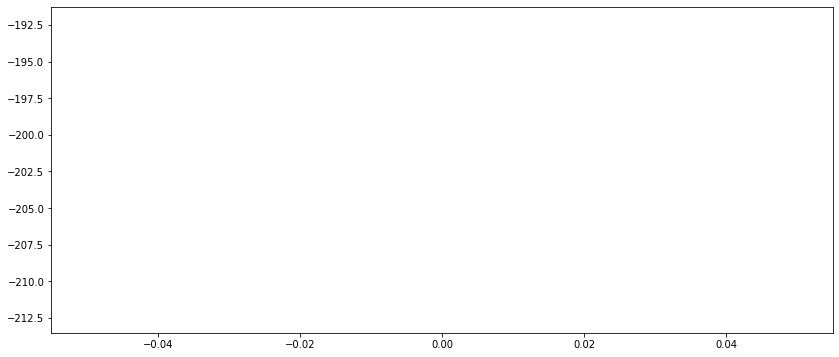

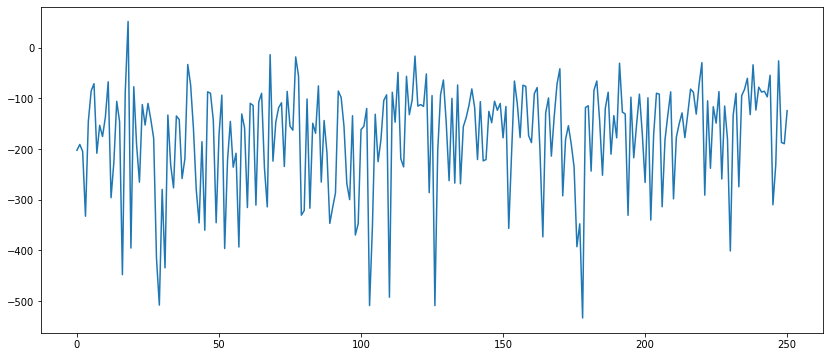

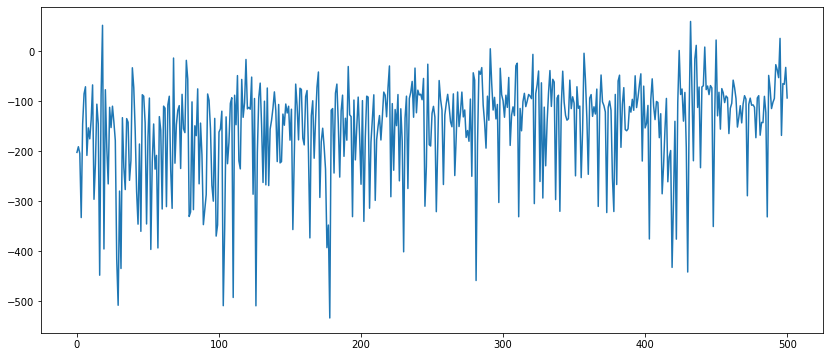

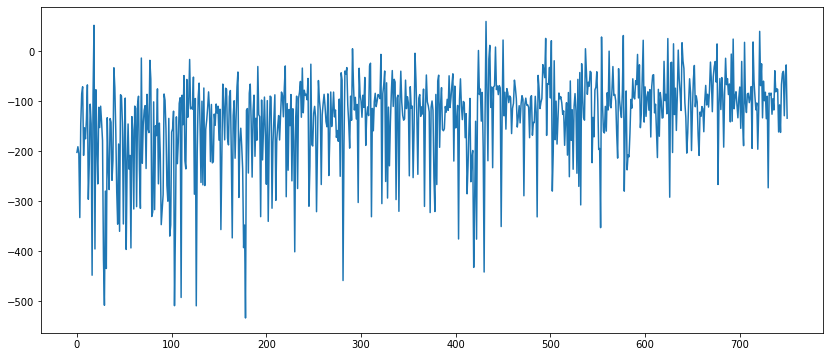

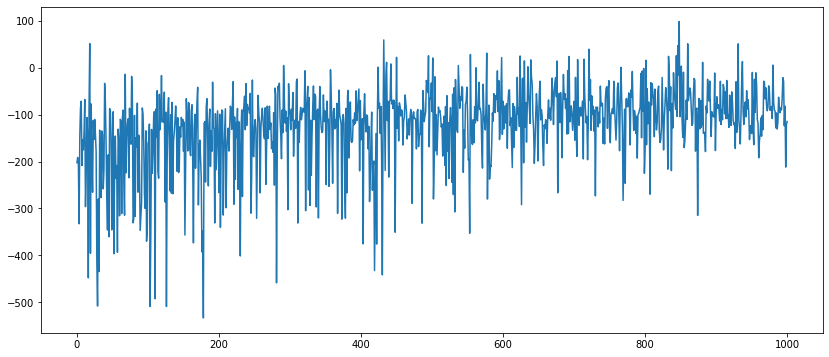

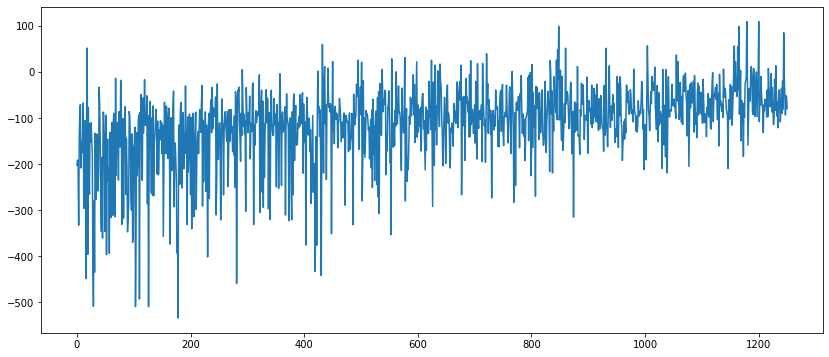

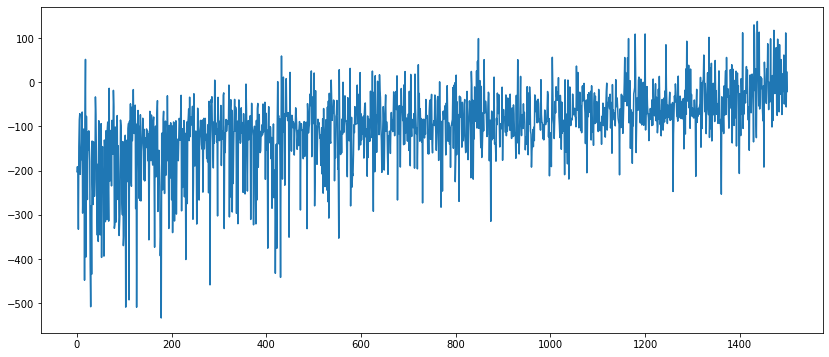

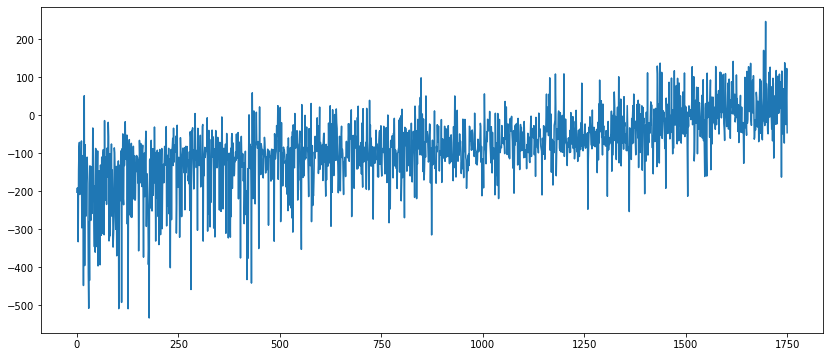

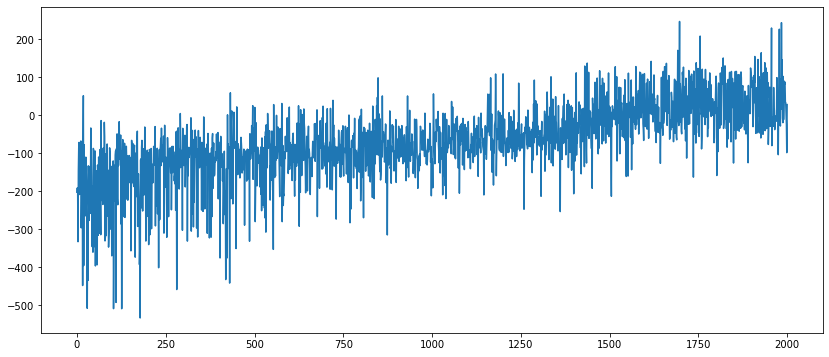

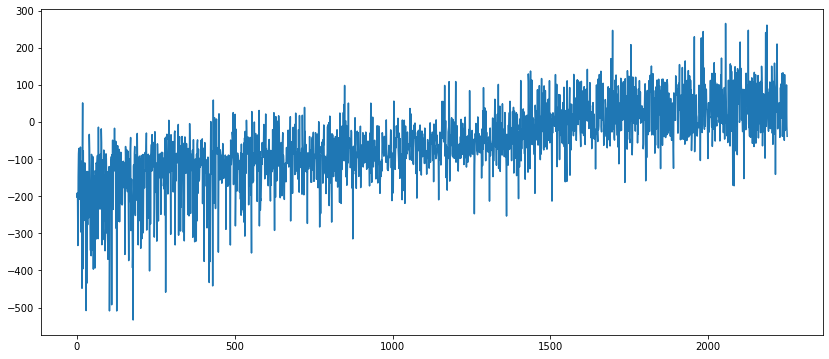

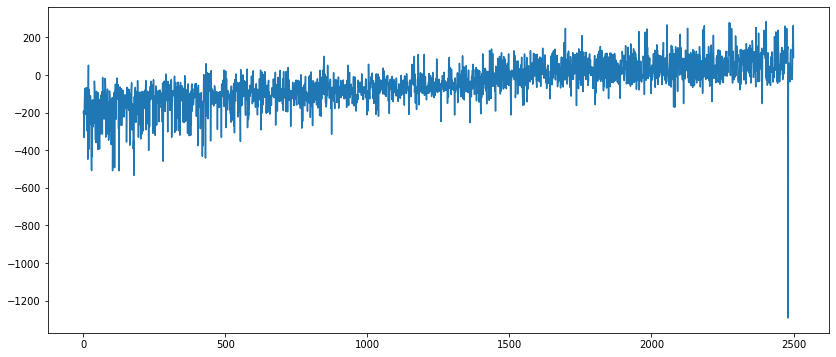

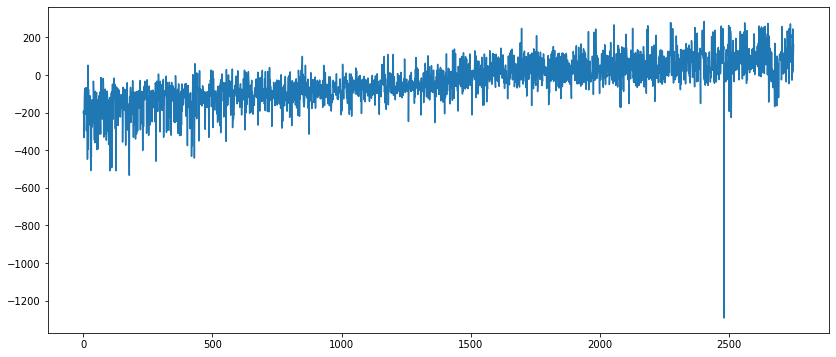

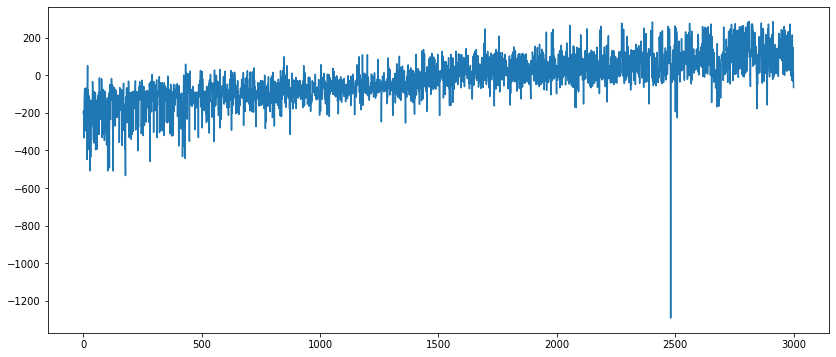

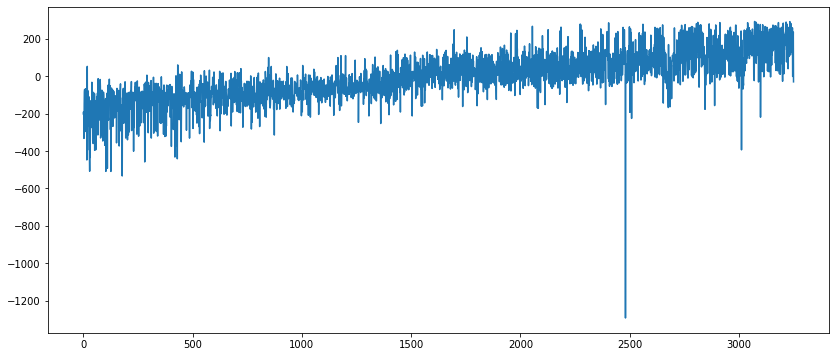

In [29]:
# Uczenie/testowania agenta
env = gym.make("LunarLander-v2")
# env = gym.make("CartPole-v1")
agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 3500, learning=True, plot=True, plot_interval=250)

In [ ]:
def run_agent_in_env_render(env, agent, episodes):
    for episode in range(episodes):
        observation = env.reset()
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, False)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            env.render()

    return rewards  

rewards = run_agent_in_env_render(env, agent, 4, learning=False, plot_interval=250)

In [ ]:
# Uczenie/testowania agenta - rozwiązanie problemu wózka w 5 minut - parametry
env = gym.make("CartPole-v1")
agent = NeuralQLearningAgent(env, batch_i=100, batch_j=500, batch_max=10000, epsilon_decrease=0.001, 
learning_rate = 0.0005, network_freezing=True, batching=True, double_q=False, freez_time=20)
# agent = NeuralQLearningAgent(env, epsilon_decrease = 0.003, learning_rate = 0.0005)
rewards = run_agent_in_env(env, agent, 4000, learning=True, plot=True, plot_interval=500)